In [ ]:
draft: false
weight: 3
description: Rhythm maps for San Diego Crime incidents, from 2007 to 2014
toc: false
show_input: show
section: notebooks
authors:
- name: Eric Busboom
github: https://github.com/sandiegodata/notebooks/blob/master/crime/Crime%20Monthly%20Rhythm%20Maps.ipynb

# Reaggregating Population Counts


Link census tract populations, total and by race, into police beats. Attributes population from tracts to beats by the areas of the overlaps. The basic procedure is to find the overlaps between beats and Census tracts, then addign a portion of the population of the tract to the beat, based on the raio of the size of overlap to the size of the tract. 

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

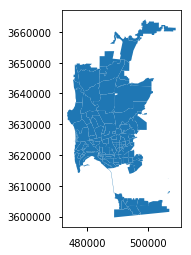

In [3]:
beats = pkg.resource('pd_beats').geoframe()

# There are  beats that are way off in east county. Get rid of them.
rightmost_centroid = beats.centroid.x.sort_values(ascending=False).iloc[:6].max()

beats = beats[beats.centroid.x <rightmost_centroid]

# Convert to EPSG:26911, ( A randomly selected UTM Zone 11N CRS) so area calculations 
# will be in square meters, rather than square degrees
beats = beats.to_crs({'init': 'epsg:26911'})

# It looks like the dataset has multiple rows per beat, one feature per row. We need
# it to have one row per beat, with multiple features combined together. 
beats = beats.dissolve(by='beat').reset_index()

#  Add the area
beats['beat_area'] = beats.area / 1_000_000

beats.plot()


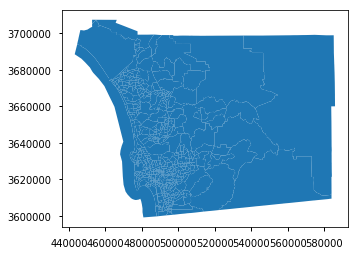

In [4]:
tracts = pkg.reference('tracts').geoframe()

tracts = tracts.to_crs({'init': 'epsg:26911'})

#  Add the area
tracts['tract_area'] = tracts.area / 1_000_000


tracts.plot()

In [5]:
from rowgenerators import parse_app_url
t = parse_app_url('census://CA/140/B03002').dataframe()

In [6]:
# White, black, asian, etc are all non hispanic. 
col_map = {
    'B03002_001':'total',
    'B03002_003':'white',
    'B03002_004':'black',
    'B03002_005':'aian',
    'B03002_006':'asian',
    'B03002_007':'nhopi', 
    'B03002_012':'hisp'
    
}

for k,v in list(col_map.items()):
    col_map[k+'_m90'] = col_map[k]+'_m90'
    
race_tracts = t[t.COUNTY=='073'].rename(columns=col_map).reset_index().rename(columns={'GEOID':'geoid'})

In [7]:
race_tracts = race_tracts[['geoid', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']]
race_tracts.titles.head().T

,0,1,2,3,4
GEOID,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
total,2773,2158,4828,4946,3916
total_m90,185,241,415,405,306
white,2276,1628,3477,3437,2655
white_m90,222,236,417,326,331
black,0,0,37,177,52
black_m90,12,12,50,138,66
aian,0,8,39,0,0
aian_m90,12,12,56,12,12
asian,84,84,368,196,475


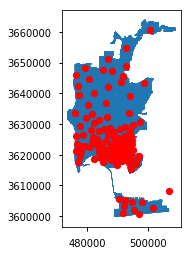

In [8]:
t = gpd.sjoin(beats, tracts)

ax = t.plot()
beats.centroid.plot(ax=ax, color='red')

t = t[['geoid', 'beat']].drop_duplicates()\
    .merge(tracts[['geoid','geometry', 'tract_area']],on='geoid')\
    .merge(beats[['beat','geometry', 'beat_area']],on='beat')


In [13]:
intr = gpd.overlay(beats, tracts, how='intersection')[['beat','geoid','geometry']]

intr['intr_area'] = (intr.geometry.area/1_000_000.0).astype(float)

# Get rid of really small intersections
intr = intr[intr.intr_area >= .01] 

merged = intr[['beat','geoid', 'intr_area']]\
    .merge(tracts[['geoid', 'tract_area']],on='geoid')\
    .merge(beats[['beat', 'beat_area']],on='beat')\
    .merge(race_tracts, on='geoid')

merged = merged.drop_duplicates(subset=['beat','geoid'])

merged['tract_overlap_proportion'] = merged.intr_area/merged.tract_area
merged['beat_overlap_proportion'] = merged.intr_area/merged.beat_area

# The intersection areas must be smaller than both of the areas being intersected
assert(not any(merged.intr_area > merged.beat_area))
assert(not any(merged.intr_area > merged.tract_area))

# Check that all of the areas of the beats are accounted for
assert(all(merged.groupby('beat').beat_overlap_proportion.sum().round(1) == 1))

merged['total'] = merged.total * merged.tract_overlap_proportion
merged['white'] = merged.white * merged.tract_overlap_proportion
merged['asian'] = merged.asian * merged.tract_overlap_proportion
merged['black'] = merged.black * merged.tract_overlap_proportion
merged['aian']  = merged.aian * merged.tract_overlap_proportion
merged['hisp']  = merged.hisp * merged.tract_overlap_proportion
merged['nhopi']  = merged.nhopi * merged.tract_overlap_proportion

merged.head().T


,0,1,2,3,4
beat,0,721,0,0,511
geoid,14000US06073021900,14000US06073021900,14000US06073021600,14000US06073003800,14000US06073003800
intr_area,0.183666,0.0228637,0.645752,0.0366767,1.77264
tract_area,10.6162,10.6162,15.2322,1.82267,1.82267
beat_area,18.2475,7.63003,18.2475,18.2475,6.80108
total,90.741,11.2959,155.544,133.613,6457.75
total_m90,1284,1284,376,1040,1040
white,29.4973,3.67198,105.137,68.8994,3330.02
white_m90,690,690,281,468,468
black,14.6016,1.81769,8.05486,26.6422,1287.66


In [15]:
beat_demographics = merged.groupby('beat').sum()[['total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']].round()